In [1]:
import torch
import numpy as np
import random
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import pandas as pd
import time
import datetime
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
#数据预处理，将网格数据处理为适合ARIMA的长序列数据，存为pandas.dataframe格式
train_path="./volume_train.npz"
test_path="./volume_test.npz"

volume_train=np.load(open(train_path,'rb'))["volume"]
volume_test=np.load(open(test_path,'rb'))["volume"]

In [3]:
#获取开始时间
time = datetime.datetime(2015,1,1,0,0,0)

In [4]:
#获取所有日期，每30分钟一个间隔
all_time=[]
add_time = datetime.timedelta(minutes=30)
for i in range(1920+960):
    all_time.append(time.strftime('%Y-%m-%d %H:%M:%S'))
    time = time + add_time

In [5]:
#取时间序列索引
train_time = all_time[:1920]
test_time = all_time[1920:]

In [6]:
#取第一个路口的入流量
volume_train=volume_train[:,0:1,0:1,0:1]
volume_test=volume_test[:,0:1,0:1,0:1]
print(volume_train.shape)  # 
print(volume_test.shape)

(1920, 1, 1, 1)
(960, 1, 1, 1)


In [7]:
#全部展开
volume_train=list(volume_train.flatten())
volume_test=list(volume_test.flatten())

In [8]:
#处理为df格式
train_df = pd.DataFrame(volume_train,columns=['Intersection_1_inflow_training'])
train_df.index=pd.to_datetime(train_time)

In [9]:
#处理为df格式
test_df = pd.DataFrame(volume_test,columns=['Intersection_1_inflow_testing'])
test_df.index=pd.to_datetime(test_time)

In [10]:
all_data = volume_train+volume_test

In [11]:
all_df = pd.DataFrame(all_data,columns=['Intersection_1_inflow_all'])
all_df.index=pd.to_datetime(all_time)

In [12]:
all_df

,Intersection_1_inflow_all
2015-01-01 00:00:00,64.0
2015-01-01 00:30:00,88.0
2015-01-01 01:00:00,102.0
2015-01-01 01:30:00,96.0
2015-01-01 02:00:00,69.0
...,...
2015-03-01 21:30:00,20.0
2015-03-01 22:00:00,21.0
2015-03-01 22:30:00,18.0
2015-03-01 23:00:00,9.0


In [13]:
train_df

,Intersection_1_inflow_training
2015-01-01 00:00:00,64.0
2015-01-01 00:30:00,88.0
2015-01-01 01:00:00,102.0
2015-01-01 01:30:00,96.0
2015-01-01 02:00:00,69.0
...,...
2015-02-09 21:30:00,56.0
2015-02-09 22:00:00,45.0
2015-02-09 22:30:00,30.0
2015-02-09 23:00:00,31.0


In [14]:
test_df

,Intersection_1_inflow_testing
2015-02-10 00:00:00,29.0
2015-02-10 00:30:00,20.0
2015-02-10 01:00:00,8.0
2015-02-10 01:30:00,17.0
2015-02-10 02:00:00,6.0
...,...
2015-03-01 21:30:00,20.0
2015-03-01 22:00:00,21.0
2015-03-01 22:30:00,18.0
2015-03-01 23:00:00,9.0


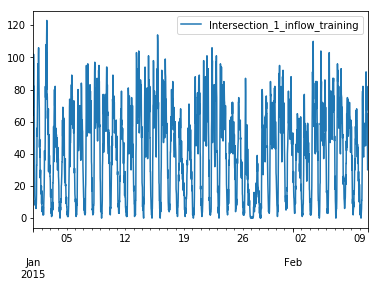

In [15]:
train_df.plot()

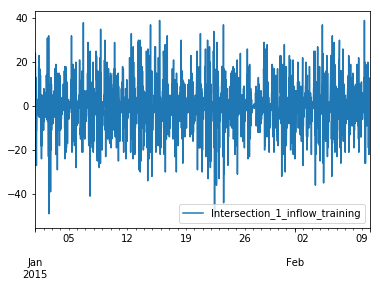

In [23]:
train_df.diff().plot()

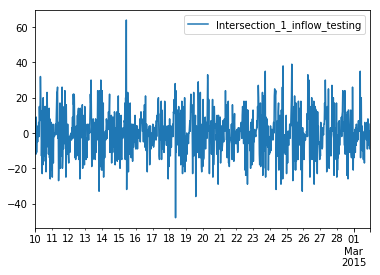

In [20]:
test_df.diff().plot()

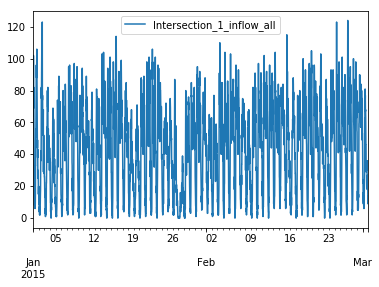

In [17]:
all_df.plot()

In [24]:
# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=30):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=30, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=30, ax=ax2)
    plt.show()

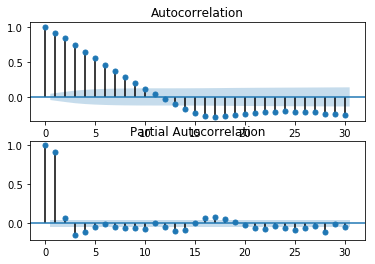

In [25]:
draw_acf_pacf(train_df)

D:\Anaconda64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
D:\Anaconda64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:     Intersection_1_inflow_training   No. Observations:                 1920
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -7354.792
Date:                            Tue, 14 Sep 2021   AIC                          14719.583
Time:                                    22:44:27   BIC                          14747.381
Sample:                                01-01-2015   HQIC                         14729.811
                                     - 02-09-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3916      0.097     -4.045      0.000      -0.581      -0.202
ma.L1          0.2203      0.103   

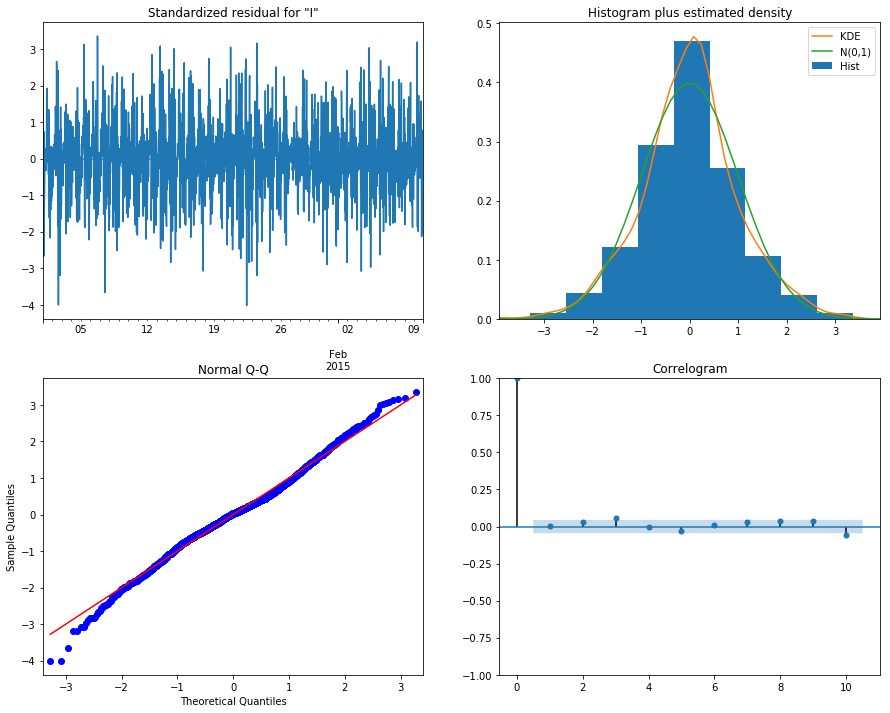

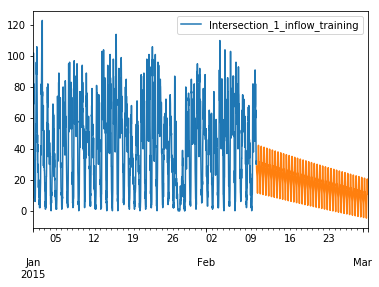

In [26]:
p1,d1,q1,P1,D1,Q1,m1=1,1,1,1,0,1,24

mod1 = sm.tsa.statespace.SARIMAX(train_df, trend='n', order=(p1,d1,q1), seasonal_order=(P1,D1,Q1,m1))
results1 = mod1.fit()
results1.plot_diagnostics(figsize=(15, 12))
print(results1.summary())
results1=results1.predict(start='2015-02-10 00:00:00',end='2015-03-01 23:30:00')
train_df.plot()
results1.plot()

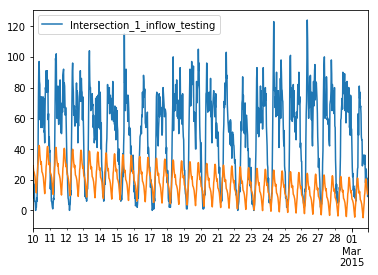

In [27]:
test_df.plot()
results1.plot()